In [61]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from typing import Union
tf.__version__

'1.15.0'

In [62]:
from tensorflow.examples.tutorials.mnist import input_data

In [63]:
def plot_histogram(weights_list: list,
                   image_name: str,
                   include_zeros=True):

    """A function to plot weights distribution"""

    weights = []
    for w in weights_list:
        weights.extend(list(w.ravel()))

    if not include_zeros:
        weights = [w for w in weights if w != 0]

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    ax.hist(weights,
            bins=100,
            facecolor='green',
            edgecolor='black',
            alpha=0.7,
            range=(-0.3, 0.3))

    ax.set_title('Weights distribution')
    ax.set_xlabel('Weights values')
    ax.set_ylabel('Number of weights')
    
    plt.show()

#     fig.savefig(image_name + '.png')
    
def number_of_parameters(var_list):
    return sum(np.prod(v.get_shape().as_list()) for v in var_list)

def mask_for_big_values(weights, pruning_threshold):

    small_weights = np.abs(weights) < pruning_threshold
    return np.logical_not(small_weights)


In [64]:
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Number of parameters (four bytes == 1 parameter): 535818.

Accuracy before training:  0.0892
epoch: 1
Test set accuracy:  0.1382
epoch: 2
Test set accuracy:  0.1135
epoch: 3
Test set accuracy:  0.1135
epoch: 4
Test set accuracy:  0.1135
epoch: 5
Test set accuracy:  0.1241
epoch: 6
Test set accuracy:  0.2255
epoch: 7
Test set accuracy:  0.3261
epoch: 8
Test set accuracy:  0.3033
epoch: 9
Test set accuracy:  0.2759
epoch: 10
Test set accuracy:  0.3319
epoch: 11
Test set accuracy:  0.4777
epoch: 12
Test set accuracy:  0.7237
epoch: 13
Test set accuracy:  0.796
epoch: 14
Test set accuracy:  0.8314
epoch: 15
Test set accuracy:  0.8533
---------------------------------------------------


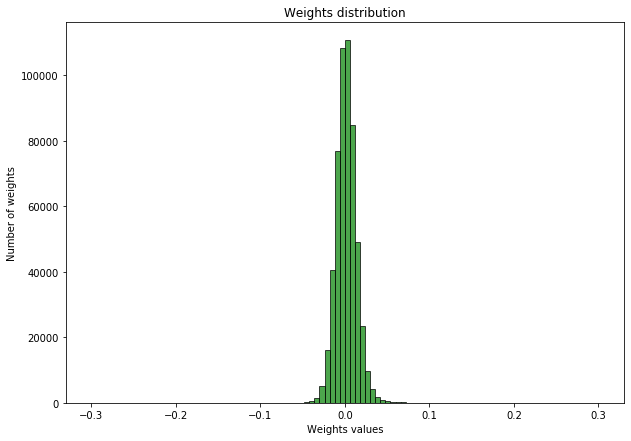

---------------------------------------------------
after pruning----------------------------------------------------------


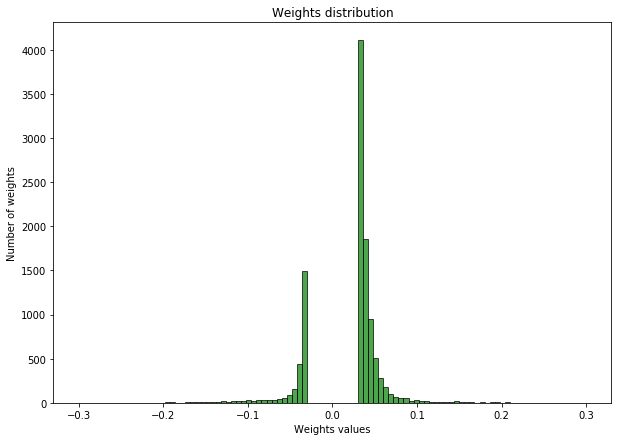

Success to save the model.


In [65]:
# tf.reset_default_graph()
batch_size = 100

n_batch = mnist.train.num_examples//batch_size

#Two placeholder
x = tf.placeholder(tf.float32,[None,784])
y = tf.placeholder(tf.float32,[None,10])

#Nural network
with tf.variable_scope('myvar',reuse=tf.AUTO_REUSE):

    W1 = tf.get_variable(name='W1',initializer=tf.random_normal([784,256])/100)
    W2 = tf.get_variable(name='W2',initializer=tf.random_normal([256,100])/100)
    W3 = tf.get_variable(name='W3',initializer=tf.random_normal([256,10])/100)

    
    b1 = tf.get_variable(name= 'b1',initializer=tf.random_normal([256])/100)
    b2 = tf.get_variable(name= 'b2',initializer=tf.random_normal([100])/100)
    b3 = tf.get_variable(name= 'b3',initializer=tf.random_normal([10])/100)



L12 = tf.nn.relu(tf.matmul(x,W1)+b1)
L23 = tf.nn.relu(tf.matmul(L12,W2)+b2)
prediction = tf.nn.softmax(tf.matmul(L23,W3)+b3)

#loss
loss = tf.reduce_mean(tf.square(y-prediction))
#Gradient decent
train_step = tf.train.GradientDescentOptimizer(learning_rate=0.15).minimize(loss)


correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
saver = tf.train.Saver()

print('Number of parameters (four bytes == 1 parameter): {}.\n'.format(int(number_of_parameters(tf.trainable_variables()))))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Weighs before training
#     print('Weighs before training')
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))


    
    acc = sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels})
    print('Accuracy before training: ',str(acc))
    
    for epoch in range(15):
        for batch in range(n_batch):
            batch_xs,batch_ys = mnist.train.next_batch(batch_size)
            sess.run(train_step,feed_dict={x:batch_xs,y:batch_ys})
            
        print('epoch:',epoch+1)
        test_acc = sess.run(accuracy,feed_dict={x:mnist.test.images,y:mnist.test.labels})
        print('Test set accuracy: ',str(test_acc))
        
        
    weights = []
    
    weights.append(sess.run(W1))
    weights.append(sess.run(W2))
    weights.append(sess.run(W3))
    weights.append(sess.run(b1))
    weights.append(sess.run(b2))
    weights.append(sess.run(b3))
    
    #Weights distribution before pruning
    print('---------------------------------------------------')
    plot_histogram(weights,'weights_distribution_after_pruning',include_zeros=False)
    print('---------------------------------------------------')
    
    
    

    
    #mask
    for weight_matrix,i in zip(weights,tf.trainable_variables()):
        #print(sess.run(i))
        mask = mask_for_big_values(weight_matrix,0.03)
        #print(mask.shape)
        sess.run(i.assign(weight_matrix * mask))
        
        
    print('after pruning----------------------------------------------------------')
    
    #See value of weights
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))

    weightsp = []
    
    weightsp.append(sess.run(W1))
    weightsp.append(sess.run(W2))
    weightsp.append(sess.run(W3))
    weightsp.append(sess.run(b1))
    weightsp.append(sess.run(b2))
    weightsp.append(sess.run(b3))
    
    #Weights distribution after pruning
    plot_histogram(weightsp,'weights_distribution_after_pruning',include_zeros=False)

        
    saver.save(sess, "./Model/model.ckpt")
    print("Success to save the model.")
    #See value of weights
#     for v in tf.trainable_variables():
#         print(v.shape)
#         print(sess.run(v))
    

In [66]:
#Load the model and inference without fine-tuning.
with tf.Session() as sess:
    saver.restore(sess, "./Model/model.ckpt") # 注意此处路径前添加"./"


    L12p1 = tf.nn.relu(tf.matmul(x,W1)+b1)
    L23p1 = tf.nn.relu(tf.matmul(L12p1,W2)+b2)
    prediction1 = tf.nn.softmax(tf.matmul(L23p1,W3)+b3)

    correct_prediction1 = tf.equal(tf.argmax(y,1),tf.argmax(prediction1,1))
    
    accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1,tf.float32))
    test_accc = sess.run(accuracy1,feed_dict={x:mnist.test.images,y:mnist.test.labels})
    print('Test accuracy after pruning without fine-tuning: ',str(test_accc))

INFO:tensorflow:Restoring parameters from ./Model/model.ckpt
Test accuracy after pruning without fine-tuning:  0.6784
